# Tumor Detection

## TO-DO

Deadline - 8/23/24 11:59pm

- EDA (title for each plot)
- hyperparam tuning with baysian optim (used - bayesian optim, use optuna)
- Project / experiment tracking with wandb
  - each expt - hyperparma.yaml, roc-auc, conf matrix, precision recall curve, test_set metrics (probably json)
- !wget
- Augmentation
- Transfer Learning (3 models with comparision)
- Saliancy Plots for  each model used including custom model and transfer learning models.
- pytorch implementation of the same project.


## Helper Functions

In [ ]:
!pip install mlflow databricks-sdk
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
import os
import sys
import imageio as iio
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import DenseNet169
import tensorflow_hub as hub
import optuna
import mlflow

## Dataset

In [ ]:
# !unrar x '/content/Testing Dataset.rar'
# # !unrar x '/content/Dataset.rar'

In [ ]:
from google.colab import drive
drive_location = '/content/drive'
drive.mount(drive_location)

Mounted at /content/drive


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Datasets/Tumor Detection/Training',
    # labels='inferred',
    # label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False
)


validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Datasets/Tumor Detection/Training',
    # labels='inferred',
    # label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Datasets/Tumor Detection/Testing',
    # labels='inferred',
    # label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    # validation_split=0.999,
    # subset='validation',
    seed=123,
    interpolation='bilinear',
    follow_links=False
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


## EDA

In [ ]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# import tensorflow as tf
# import pandas as pd

# # Lists to hold image data and labels
# image_data = []
# labels = []

# # Iterate over the dataset and collect data
# for image, label in train_ds:
#     image_data.append(image.numpy())
#     labels.append(label.numpy())

# # Create a DataFrame
# df = pd.DataFrame({
#     'Image': image_data,
#     'Label': labels
# })

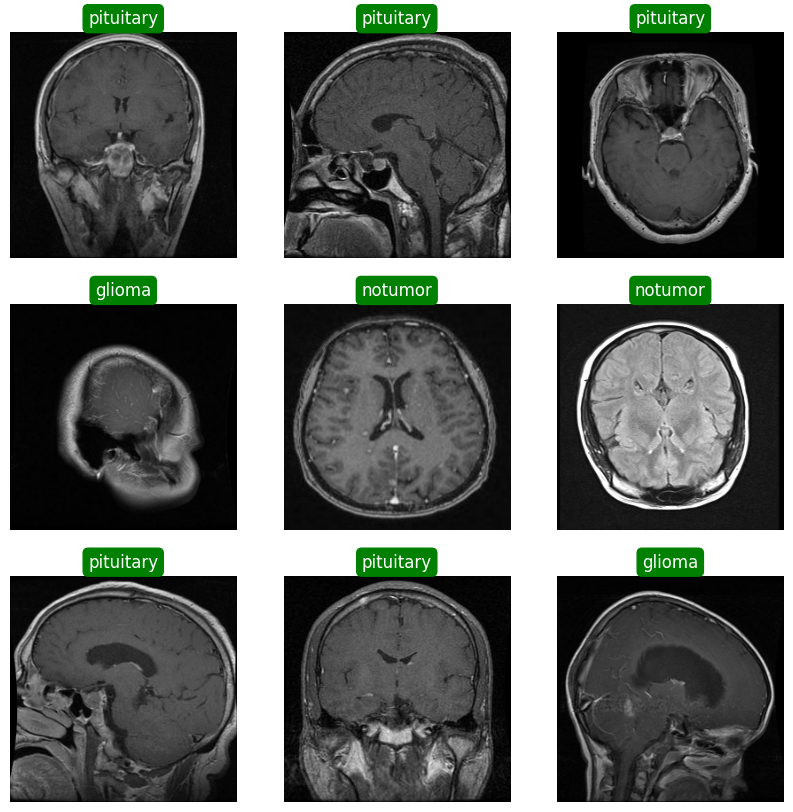

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(9):
  for images, labels in train_ds.take(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))

    plt.title(f"{class_names[labels[0].numpy()]}", color='white', bbox=dict(boxstyle="round", color='green'))

    plt.axis("off")

## Data Preprocessing

In [ ]:
# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),               # Flip images horizontally
    tf.keras.layers.RandomRotation(0.1),                    # Randomly rotate images by 10%
    tf.keras.layers.RandomZoom(0.1),                        # Randomly zoom images by 10%
    tf.keras.layers.RandomContrast(0.1),                    # Adjust contrast
])

# Apply data augmentation to the training dataset
def augment_images(image, label):
    image = data_augmentation(image)                        # Apply the augmentation
    return image, label

# Map the augmentation function over the dataset
train_ds = train_ds.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for optimized performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# # Function to build the model with hyperparameters
# def create_model(trial):
#     # Hyperparameters to tune
#     num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
#     num_filters = trial.suggest_int("num_filters", 32, 128)
#     kernel_size = trial.suggest_int("kernel_size", 3, 5)
#     dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
#     learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2)

#     # Build the model
#     model = Sequential([
#     layers.Rescaling(1./255, input_shape=(256, 256, 3)),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(len(class_names))
#     ])

#     # Compile the model
#     model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

#     return model

# # Function to train the model and evaluate its performance
# def objective(trial):
#     model = create_model(trial)

#     # # Load your prefetched training and validation datasets
#     # train_dataset = tf.data.Dataset.load("path/to/your/train_dataset.tfrecord")
#     # val_dataset = tf.data.Dataset.load("path/to/your/val_dataset.tfrecord")

#     # # Preprocess and augment data (if needed)
#     # train_dataset = train_dataset.map(your_preprocessing_function)
#     # val_dataset = val_dataset.map(your_preprocessing_function)

#     # Train the model
#     history = model.fit(train_ds, validation_data=validation_ds, batch_size=32, epochs=10)

#     # Evaluate the model on the validation set
#     val_accuracy = history.history['val_accuracy'][-1]

#     return val_accuracy

# # Create an Optuna study
# study = optuna.create_study(direction="maximize")

# # Run the optimization process
# study.optimize(objective, n_trials=10)

# # Get the best trial and its parameters
# best_trial = study.best_trial
# print("Best trial:")
# print(f"  Value: {best_trial.value}")
# print(f"  Params: {best_trial.params}")

In [ ]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# normalization_layer = layers.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

0.0 0.96274513


## MLFlow

In [ ]:
mlflow.login()

2024/11/17 02:44:20 INFO mlflow.utils.credentials: No valid Databricks credentials found, please enter your credentials...


Databricks Host (should begin with https://): community.cloud.databricks.com


2024/11/17 02:44:50 ERROR mlflow.utils.credentials: Invalid host: {host}, host must begin with https://, please retry.


Username: aadarshcoursera@gmail.com
Password: ··········


2024/11/17 02:45:00 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [ ]:
mlflow.set_experiment("/mlflow-brain-tumor")

mlflow.tensorflow.autolog()

# model.fit(x=train_ds, epochs=10)

2024/11/17 02:45:01 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.17.1. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


## Model Training

In [ ]:
def create_model_with_params(params):
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
    ])

    for _ in range(params['num_conv_layers']):
        model.add(Conv2D(params['num_filters'], (params['kernel_size'], params['kernel_size']), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(len(class_names)))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model


# Training with specified parameters
params = {'num_conv_layers': 1, 'num_filters': 121, 'kernel_size': 5, 'dropout_rate': 0.07422465083374463, 'learning_rate': 0.009710854444439516}
model = create_model_with_params(params)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 275ms/step - accuracy: 0.5686 - loss: 69.3105 - val_accuracy: 0.8634 - val_loss: 0.4234
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - accuracy: 0.9017 - loss: 0.3236 - val_accuracy: 0.8765 - val_loss: 0.4608
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.9414 - loss: 0.1605 - val_accuracy: 0.8739 - val_loss: 0.5656
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - accuracy: 0.9748 - loss: 0.0799 - val_accuracy: 0.8792 - val_loss: 0.5754
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9806 - loss: 0.0869 - val_accuracy: 0.8669 - val_loss: 0.7521
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.9865 - loss: 0.0432 - val_accuracy: 0.8853 - val_loss: 0.6691
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.9875 - loss: 0.0379 - val_accuracy: 0.8687 - val_loss: 1.2408
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step - accuracy: 0.9558 - loss: 

### With MLFlow

In [ ]:
# from mlflow.types import Schema, TensorSpec
# from mlflow.models import ModelSignature

# batch_size = 32
# img_height = 256
# img_width = 256

# num_classes = len(class_names)

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

# # input_schema = Schema(
# #     [
# #         TensorSpec(np.dtype(np.float32), (-1, 256, 256, 3), "input"),
# #     ]
# # )
# # signature = ModelSignature(inputs=input_schema)

# # with mlflow.start_run() as run:
# #     mlflow.tensorflow.log_model(model, "model", signature=signature)

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
with mlflow.start_run():
  # Train the model
  history = model.fit(train_ds, validation_data=validation_ds, epochs=10)
  y_pred = clf.predict(test)
  test_accuracy = metrics.accuracy_score(y_test, y_pred)
  test_f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
  test_metrics = (test_accuracy, test_f1_score)

  mlflow.log_metric('test_accuracy' , test_accuracy)
  mlflow.log_metric('test_f1_score', test_f1_score)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9945 - loss: 0.0214

Uploading /tmp/tmp85z1fh0c/latest_checkpoint.h5:   0%|          | 0.00/2.75G [00:00<?, ?iB/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9945 - loss: 0.0215 - val_accuracy: 0.8993 - val_loss: 1.1026
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9843 - loss: 0.0532

Uploading /tmp/tmp62lheurf/latest_checkpoint.h5:   0%|          | 0.00/2.75G [00:00<?, ?iB/s]

143/143 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9843 - loss: 0.0531 - val_accuracy: 0.9072 - val_loss: 0.8048
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.9954 - loss: 0.0181 - val_accuracy: 0.9019 - val_loss: 0.8189
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.9891 - loss: 0.0327 - val_accuracy: 0.8914 - val_loss: 1.2899
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.9857 - loss: 0.0728 - val_accuracy: 0.8809 - val_loss: 1.4091
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.9864 - loss: 0.0651 - val_accuracy: 0.8809 - val_loss: 1.2041
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.9826 - loss: 0.0616 - val_accuracy: 0.8730 - val_loss: 1.8660
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - accuracy: 0.9856 - loss: 0.0575 - val_accuracy: 0.8879 - val_loss: 1.8122
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.9821 - loss: 0.0840 - val_a

2024/11/13 00:31:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdxri4rcp/model, flavor: tensorflow). Fall back to return ['tensorflow==2.17.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


Uploading artifacts:   0%|          | 0/7 [00:00<?, ?it/s]

Uploading /tmp/tmpdxri4rcp/model/data/model.keras:   0%|          | 0.00/2.75G [00:00<?, ?iB/s]

Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

2024/11/13 00:32:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-loon-488 at: community.cloud.databricks.com/ml/experiments/2208100388204680/runs/226ffad0630140e3a6e3fac99de77537.
2024/11/13 00:32:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: community.cloud.databricks.com/ml/experiments/2208100388204680.


### Accuracy Plot

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Transfer Learning

### EfficientNetB0

In [ ]:
# Load the pre-trained EfficientNetB0 model without the top (fully connected) layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model so they aren't trained
base_model.trainable = False

# Build your custom model on top of the pre-trained base
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes: tumor, pituitary, glioma, meningioma
])

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # or categorical_crossentropy depending on label encoding
    metrics=['accuracy']
)

# Train the model
with mlflow.start_run():
  # Train the model
  history = model.fit(train_ds, validation_data=validation_ds, epochs=10)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1485s 10s/step - accuracy: 0.7163 - loss: 0.6916 - val_accuracy: 0.8949 - val_loss: 0.3050
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.8628 - loss: 0.3595 - val_accuracy: 0.8713 - val_loss: 0.3187
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - accuracy: 0.8808 - loss: 0.3049 - val_accuracy: 0.8932 - val_loss: 0.2684
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.8944 - loss: 0.2901 - val_accuracy: 0.9142 - val_loss: 0.2244
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 179ms/step - accuracy: 0.9154 - loss: 0.2351 - val_accuracy: 0.9299 - val_loss: 0.1981
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 159ms/step - accuracy: 0.9223 - loss: 0.2095 - val_accuracy: 0.9370 - val_loss: 0.1814
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9254 - loss: 0.1962 - val_accuracy: 0.9124 - val_loss: 0.2147
Epoch 8/10
143/143 ━━━━━━━━━━━━━

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels

loss, accuracy = model.evaluate(test_ds)  # Evaluate model performance
print("Test loss:", loss)
print("Test accuracy:", accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 448s 11s/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9464 - loss: 0.1406
Test loss: 0.14819514751434326
Test accuracy: 0.936689555644989


### DenseNet169

In [ ]:
# Load the pre-trained DenseNet169 model without the top (fully connected) layers
base_DN_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model so they aren't trained
base_DN_model.trainable = False

# Build your custom model on top of the pre-trained base
model_DN169 = models.Sequential([
    base_DN_model,  # Pre-trained DenseNet169
    layers.GlobalAveragePooling2D(),  # Global pooling to reduce the feature map to a vector
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(4, activation='softmax')  # 4 output classes: tumor, pituitary, glioma, meningioma
])

# Compile the model with an appropriate optimizer, loss function, and metrics
model_DN169.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # or categorical_crossentropy depending on label encoding
    metrics=['accuracy']
)

# Train the model
with mlflow.start_run():
    # Train the model
    history = model_DN169.fit(train_ds, validation_data=validation_ds, epochs=10)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 494ms/step - accuracy: 0.4755 - loss: 1.9085 - val_accuracy: 0.7434 - val_loss: 0.6789
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 175ms/step - accuracy: 0.7042 - loss: 0.7275 - val_accuracy: 0.7636 - val_loss: 0.6006
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.7502 - loss: 0.6191 - val_accuracy: 0.7933 - val_loss: 0.5537
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.7703 - loss: 0.5781 - val_accuracy: 0.8327 - val_loss: 0.4473
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.7780 - loss: 0.5409 - val_accuracy: 0.8441 - val_loss: 0.4497
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 179ms/step - accuracy: 0.7947 - loss: 0.5288 - val_accuracy: 0.8319 - val_loss: 0.4373
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.7969 - loss: 0.4749 - val_accuracy: 0.8573 - val_loss: 0.3947
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.8119 - loss: 

In [ ]:
predictions = model_DN169.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels

loss, accuracy = model_DN169.evaluate(test_ds)  # Evaluate model performance
print("Test loss:", loss)
print("Test accuracy:", accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - accuracy: 0.7999 - loss: 0.4453
Test loss: 0.4366377890110016
Test accuracy: 0.8085430860519409


### Visual Transformation (Discarded)

In [ ]:
# # Load the pre-trained ViT model without the top layers
# base_vit_model = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False)

# # Define the input shape
# input_shape = (256, 256, 3)  # or adjust based on your dataset requirements
# inputs = tf.keras.Input(shape=input_shape)

# # Pass inputs through the ViT model
# x = base_vit_model(inputs)

# # Add custom layers on top of the ViT model
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(4, activation='softmax')(x)  # 4 output classes

# # Build the model
# model = Model(inputs, outputs)

# # Compile the model
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss='sparse_categorical_crossentropy',  # or categorical_crossentropy depending on label encoding
#     metrics=['accuracy']
# )

# # Train the model
# with mlflow.start_run():
#     history = model.fit(train_ds, validation_data=validation_ds, epochs=10)

ValueError: Exception encountered when calling layer 'keras_layer_1' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_1' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_2048>
  • training=None

## Prediction on unseen image data

In [ ]:
logged_model = 'runs:/e4f39b4471854bd9bba3e5b950c92d61/model'
loaded_model = mlflow.pyfunc.load_model(logged_model)

2024/06/28 10:41:52 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.14.1, required: mlflow==2.14.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = loaded_model.evaluate(test_ds, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
img = tf.keras.utils.load_img(
    '/content/1 BGxLxoHd8MG9m8gesYIprw.jpg', target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = loaded_model.predict(np.array(img_array))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 44ms/step
This image most likely belongs to notumor with a 100.00 percent confidence.


In [ ]:
# model.save("convolution_model.h5")